Name : Sudharshan Vijayaragavan

Reg No: 3122237001054

1. Load and Preprocess Dataset

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Load dataset (WDBC)
file_path = "/content/sample_data/wdbc.data"
columns = ["ID", "Diagnosis"] + [f"feat_{i}" for i in range(1, 31)]
df = pd.read_csv(file_path, header=None, names=columns)

# Drop ID column
df.drop("ID", axis=1, inplace=True)

# Encode Diagnosis (M=1, B=0)
df["Diagnosis"] = LabelEncoder().fit_transform(df["Diagnosis"])

# Features & target
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

# Handle missing values with median
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Normalize features (MinMax scaling)
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

print("✅ Data prepared! Shape:", X_norm.shape)
print("Class counts:\n", y.value_counts())


✅ Data prepared! Shape: (569, 30)
Class counts:
 Diagnosis
0    357
1    212
Name: count, dtype: int64


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. EDA (Class Balance & Feature Correlation)

/tmp/ipython-input-3393333287.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


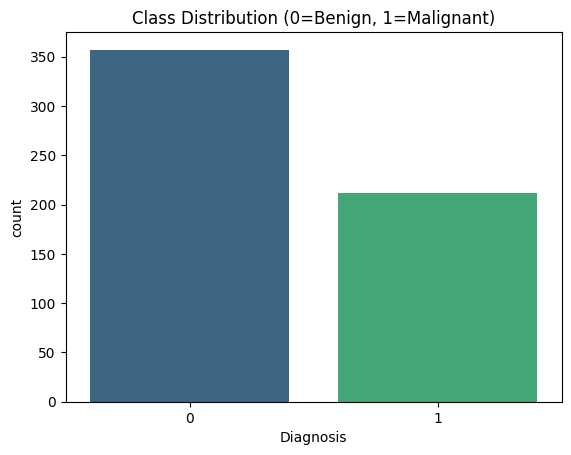

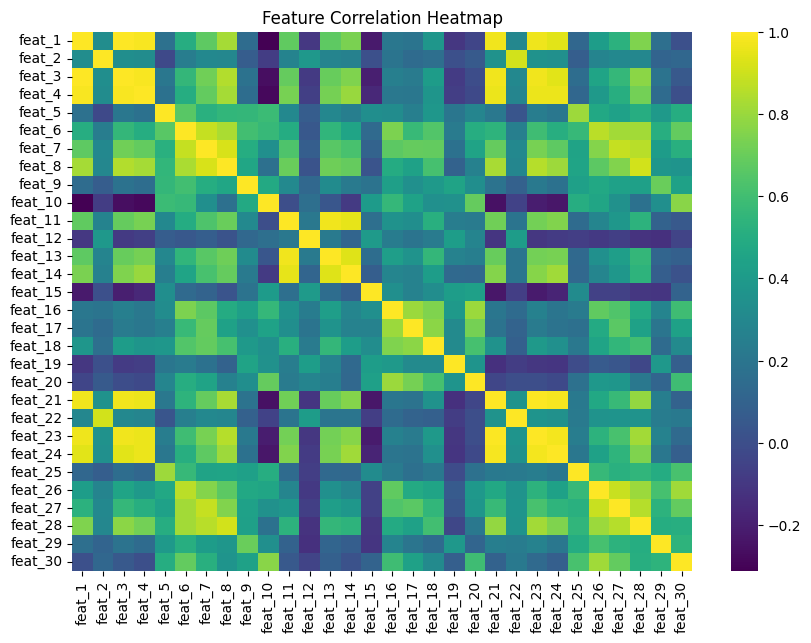

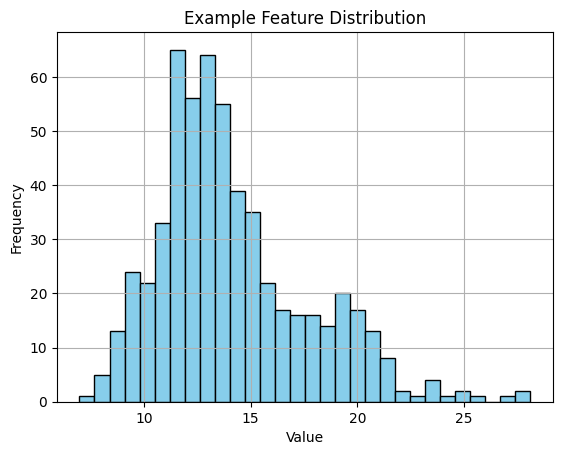

In [8]:

# Quick EDA
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution (0=Benign, 1=Malignant)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,7))
sns.heatmap(pd.DataFrame(X_norm, columns=X.columns).corr(), cmap="viridis")
plt.title("Feature Correlation Heatmap")
plt.show()

# Example feature histogram
X.iloc[:,0].hist(bins=30, color="skyblue", edgecolor="black")
plt.title("Example Feature Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


3. Training, Validation & Test the dataset

In [9]:

# Train/Val/Test split (70/15/15)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_norm, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1765, stratify=y_train_full, random_state=42
)
# (0.1765 ~ 15% of total, so 70/15/15)
print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


Train: (397, 30) Valid: (86, 30) Test: (86, 30)


4. Training the Models

In [10]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

models = {
    "DT_Classifier": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "RandForest": RandomForestClassifier(random_state=42),
    "Voting": VotingClassifier(
        estimators=[
            ("dt", DecisionTreeClassifier(random_state=42)),
            ("rf", RandomForestClassifier(random_state=42))
        ],
        voting="soft"
    )
}


5. Hyperparameter Tuning with GridSearchCV and 5-Fold Cross-Validation

In [11]:

param_grids = {
    "DT_Classifier": {"max_depth": [4, 6, None], "criterion": ["gini", "entropy"]},
    "AdaBoost": {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1, 1.0]},
    "GradBoost": {"n_estimators": [100, 150], "learning_rate": [0.05, 0.1], "max_depth": [3, 4]},
    "XGBoost": {"n_estimators": [100, 150], "learning_rate": [0.05, 0.1], "max_depth": [3, 4]},
    "RandForest": {"n_estimators": [100, 200], "max_depth": [None, 6], "criterion": ["gini"]},
    "Voting": {"voting": ["soft"]}
}

# Hyperparameter tuning with 5-fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
optimized_models = {}

for name, model in models.items():
    print(f"🔎 Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=cv, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    optimized_models[name] = grid.best_estimator_
    print("Best params:", grid.best_params_)


🔎 Tuning DT_Classifier...
Best params: {'criterion': 'gini', 'max_depth': 4}
🔎 Tuning AdaBoost...
Best params: {'learning_rate': 1.0, 'n_estimators': 100}
🔎 Tuning GradBoost...
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
🔎 Tuning XGBoost...
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
🔎 Tuning RandForest...
Best params: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}
🔎 Tuning Voting...
Best params: {'voting': 'soft'}


6. ROC Curves with data metrics


DT_Classifier: Acc=0.977, Prec=1.000, Rec=0.938, F1=0.968
Confusion Matrix:
 [[54  0]
 [ 2 30]]

AdaBoost: Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Confusion Matrix:
 [[54  0]
 [ 0 32]]

GradBoost: Acc=0.988, Prec=1.000, Rec=0.969, F1=0.984
Confusion Matrix:
 [[54  0]
 [ 1 31]]

XGBoost: Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Confusion Matrix:
 [[54  0]
 [ 0 32]]

RandForest: Acc=0.988, Prec=1.000, Rec=0.969, F1=0.984
Confusion Matrix:
 [[54  0]
 [ 1 31]]

Voting: Acc=0.953, Prec=0.912, Rec=0.969, F1=0.939
Confusion Matrix:
 [[51  3]
 [ 1 31]]


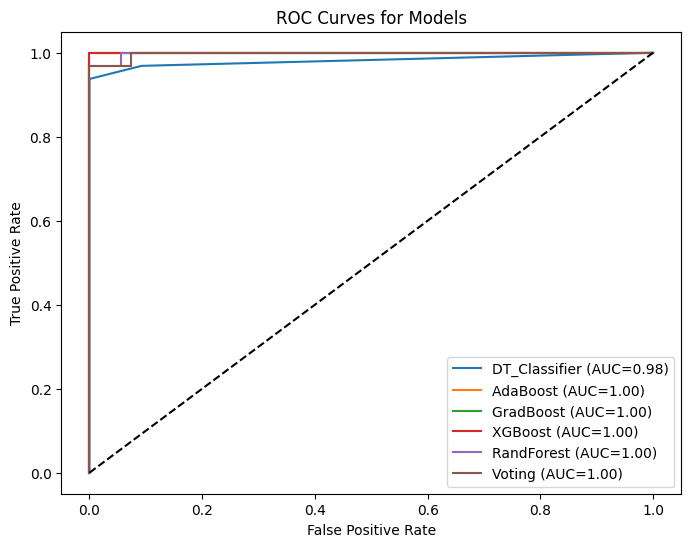

In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

plt.figure(figsize=(8,6))

for name, model in optimized_models.items():
    model.fit(X_train_full, y_train_full)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()
